# Data Preprocessing

### Libraries

- `glob`: Provides a way to find all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.

- `json`: Provides methods to manipulate JSON objects, including serialization and deserialization.

- `seaborn`: Provides a high-level interface for drawing attractive and informative statistical graphics.

- `re`: Provides regular expression matching operations similar to those found in Perl.

- `nltk`: Provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning.

- `langdetect`: Provides functionality to detect the natural language of a text.

- `string`: Provides constants that represent the ASCII characters defined by the character set ANSI X3.4-1977 ('ASCII').

- `spacy`: Provides industrial-strength Natural Language Processing (NLP) with pre-trained statistical models and word vectors, as well as deep learning models.

- `en_core_web_sm`: Provides a small English model trained on web text.

- `statistics`: Provides functions for calculating mathematical statistics of numeric data.

In [1]:
import numpy as np 
import pandas as pd 
import glob 
import json 

import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import warnings 
warnings.filterwarnings("ignore")

from wordcloud import WordCloud

import statistics
import seaborn as sns 
import re 
import nltk
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import langdetect

#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
import string

## Code Explanation 

The given code defines a class `Preprocessing` that is used for data preprocessing and visualization. 

- `__init__`: Initializes the instance with a path to the data file and reads the data into a pandas DataFrame.

- `descriptor`: Prints basic information about the dataset, such as the first five rows, dimensions, info, and data types of the columns.

- `visualizer`: Generates word clouds for the 'title' and 'abstract' fields of the dataset.

- `clean_text`: Cleans the input text by replacing strange quotes, converting to lowercase, removing emails, numbers, and punctuation, replacing multiple spaces with a single space, removing stop words, and performing stemming.

- `dataCleaning`: Cleans the data by dropping unnecessary columns, filling null values, replacing null values with the median of the years, removing duplicates, detecting and filtering out non-English texts, removing specific symbols, and applying the `clean_text` method to the 'title' and 'abstract' fields. The cleaned data is then saved as a CSV file.


This class is likely used in a larger machine learning or data analysis pipeline, where the raw data needs to be cleaned and processed before further analysis.

In [2]:
class Preprocessing:
    def __init__(self, path):
        self.path = path 
        self.meta_df = pd.read_csv(path, dtype={
            'pubmed_id': str,
            'Microsoft Academic Paper ID': str, 
            'doi': str
        })
        
            
    def descriptor(self):
        print(" Basic information from dataset:")
        print("-" * 100)
        print(" First 5 rows dataset")
        print(self.meta_df.head())
        print("-" * 100)
        
        print("\n Dimensions of the dataset:")
        print(self.meta_df.shape)
        print("-" * 100)
        
        print("\n Info of the data:")
        print(self.meta_df.info())
        print("-" * 100)

        print("\n Checking the datatypes of the columns")
        print(self.meta_df.dtypes)
        print("-" * 100)

    def visualizer(self):

        print("-" * 100)
        text = ' '.join(self.meta_df['title'].astype(str))
        wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(text)
        # Display the word cloud using matplotlib
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f'Word Cloud for title')
        plt.axis('off')
        plt.show()

        print("-" * 100)
        text = ' '.join(self.meta_df['abstract'].astype(str))
        wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(text)
        # Display the word cloud using matplotlib
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f'Word Cloud for abstract')
        plt.axis('off')
        plt.show()

    
   

    def clean_text(self, text):

        self.strange_double_quotes = [
            "«",
            "‹",
            "»",
            "›",
            "„",
            "“",
            "‟",
            "”",
            "❝",
            "❞",
            "❮",
            "❯",
            "〝",
            "〞",
            "〟",
            "＂",
        ]
        self.strange_single_quotes = ["‘", "‛", "’", "❛", "❜", "`", "´", "‘", "’"]
        """
        1. Replace strange quotes. 
        """
        text = re.compile("|".join(self.strange_single_quotes)).sub('', text)
        text = re.compile("|".join(self.strange_double_quotes)).sub('', text)

        """
        2. Replace upper case with lower. 
        """
        text = text.lower()
        
        """
        3. Replace Emails.
        """
        text = re.compile(
                r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-](@|[(<{\[]at[)>}\]])(?:(?:[a-z\\u00a1-\\uffff0-9]-?)*[a-z\\u00a1-\\uffff0-9]+)(?:\.(?:[a-z\\u00a1-\\uffff0-9]-?)*[a-z\\u00a1-\\uffff0-9]+)*(?:\.(?:[a-z\\u00a1-\\uffff]{2,}))",
                flags=re.IGNORECASE | re.UNICODE,
            ).sub(" " , text)
        
        """
        4. Replace Numbers.
        """         
        text = re.sub(r'\d+', ' ', text)
        
        """
        5. Replace one or more spacings with a single space.
        """
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'-|_|--|__', ' ', text)

        """
        6. Replace Punctuations.
        """
        text = re.sub(r'[\\|"|.|,|(|)|{|}|\[|\]|?|!|<|>]', ' ', text)
        text = re.sub(r'( - )(--)(/)(\\)()', ' ', text)      
        # text = re.sub(r"\s*\/\s*|-\s*|\s*-|\s-\s|\.", ' ', text)
        text = re.sub(r"\.|\+|\=|_|…|,|\(|\)", " ", text)


        """
        7. Replace Stop words.
        """
        # Get a list of English stopwords
        try:
            nltk.data.find('corpora/stopwords')
        except LookupError:
            # Download the stopwords if they are not already downloaded
            nltk.download('stopwords', quiet=True)
        stop_words = stopwords.words('english')
        # Remove stop words from the text
        text = ' '.join([word for word in text.split() if word not in stop_words])

        """
        12. Stemming.
        """
        # Tokenize the text into words
        words = word_tokenize(text)

        # Create a stemmer
        stemmer = PorterStemmer()

        # Stem each word in the text
        text = " ".join([stemmer.stem(word) for word in words])


        # Remove specific symbols
        text = re.sub(r'φ|σ|μ', '', text)
        
        # """
        # 13. Lemmatization.
        # """
        # nltk.download('punkt')
        # nltk.download('wordnet')
        # # Tokenize the text into words
        # words = word_tokenize(text)
        # # Create a lemmatizer
        # lemmatizer = WordNetLemmatizer()
        # # Lemmatize each word in the text
        # text = " ".join([lemmatizer.lemmatize(word) for word in words])

        return text 


    def dataCleaning(self):

        print("-" * 100)
        print("     Descriptor function after dropping useless columns\n")
        self.meta_df = self.meta_df[['title', 'abstract', 'publish_time']]
        print("     Before Filling null values: \n")
        self.descriptor()

        years=[]
        for date in self.meta_df['publish_time']:
            if str(date) != 'nan':
                years.append(int(str(date)[:4]))
        years_median = statistics.median(years)

        # plot of years distribution 
        fig, axes = plt.subplots(1, 3, figsize=(15,5))
        sns.boxplot(years, showfliers=True, ax= axes[0])
        sns.boxplot(years, showfliers=False, ax= axes[1])
        sns.histplot(years, kde=True, ax=axes[2])
        plt.xlabel("Distribution of years")
        plt.show()
        
        # replace null value of publish time with median of the years. 
        self.meta_df['publish_time'] = self.meta_df['publish_time'].fillna(years_median, inplace=True)

        # considering just year value in publish time 
        self.meta_df['publish_time'] = self.meta_df['publish_time'].apply(lambda x : str(x)[:4])

        self.meta_df = self.meta_df.dropna(subset=['title'])
        self.meta_df = self.meta_df.dropna(subset=['abstract'])

        
        # droping duplicates base on title and abstract 
        duplicates = self.meta_df.duplicated(subset=['title', 'abstract'])
        self.meta_df = self.meta_df.drop_duplicates()

        def detect_language(text):
            try :
                return langdetect.detect(text)
            except:
                return 'unkonwn'
        
        self.meta_df['language'] = self.meta_df['abstract'].apply(detect_language)
        self.meta_df = self.meta_df[self.meta_df['language']== 'en']


        punctuations = string.punctuation
        stopwords = list(STOP_WORDS)
        print(stopwords[:10])
        custom_stop_words = [
            'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
            'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
            'al.', 'Elsevier', 'PMC', 'CZI', 'www'
        ]

        for w in custom_stop_words:
            if w not in stopwords:
                stopwords.append(w)
        
        # Parser
        parser = en_core_web_sm.load(disable=["tagger", "ner"])
        parser.max_length = 7000000
        def spacy_tokenizer(sentence):
            mytokens = parser(sentence)
            mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
            mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
            mytokens = " ".join([i for i in mytokens])
            return mytokens 

        self.meta_df['abstract'] = self.meta_df['abstract'].apply(lambda text : self.clean_text(str(text)))
        self.meta_df['abstract'] = self.meta_df['abstract'].apply(spacy_tokenizer)
        self.meta_df['title'] = self.meta_df['title'].apply(lambda text : self.clean_text(str(text)))
        self.meta_df['title'] = self.meta_df['title'].apply(spacy_tokenizer)
        

        # Save the dataframe as an csv after cleaning preprocessing 
        self.meta_df.to_csv("/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/proceed_data/cleaned_dataset.csv")     


 Basic information from dataset:
----------------------------------------------------------------------------------------------------
 First 5 rows dataset
                                        sha source_x  \
0  c630ebcdf30652f0422c3ec12a00b50241dc9bd9      CZI   
1  53eccda7977a31e3d0f565c884da036b1e85438e      CZI   
2  210a892deb1c61577f6fba58505fd65356ce6636      CZI   
3  e3b40cc8e0e137c416b4a2273a4dca94ae8178cc      CZI   
4  92c2c9839304b4f2bc1276d41b1aa885d8b364fd      CZI   

                                               title  \
0  Angiotensin-converting enzyme 2 (ACE2) as a SA...   
1  Comparative genetic analysis of the novel coro...   
2  Incubation Period and Other Epidemiological Ch...   
3  Characteristics of and Public Health Responses...   
4       Imaging changes in severe COVID-19 pneumonia   

                          doi pmcid pubmed_id   license  \
0  10.1007/s00134-020-05985-9   NaN  32125455  cc-by-nc   
1   10.1038/s41421-020-0147-1   NaN       NaN     cc

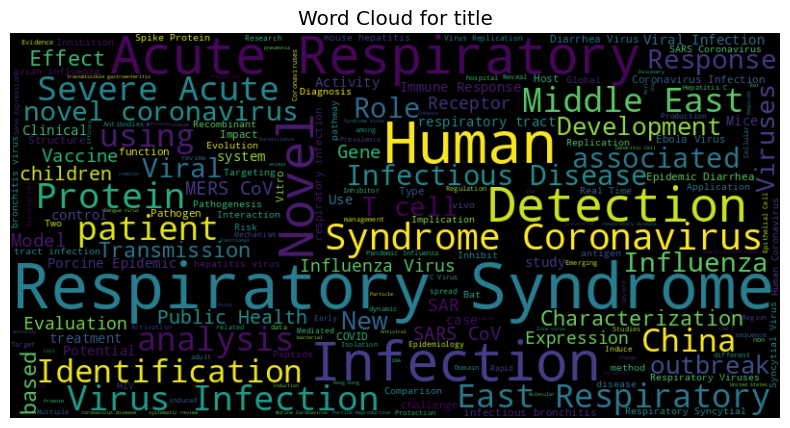

----------------------------------------------------------------------------------------------------


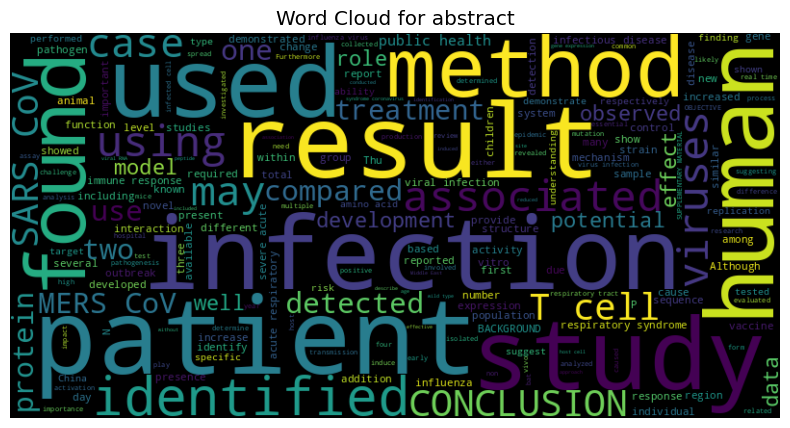

In [3]:
path = "/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/raw_data/DM_PRJ_03/all_sources_metadata_2020-03-13.csv"
preprocess = Preprocessing(path)
preprocess.descriptor()
preprocess.visualizer()

----------------------------------------------------------------------------------------------------
     Descriptor function after dropping useless columns

     Before Filling null values: 

 Basic information from dataset:
----------------------------------------------------------------------------------------------------
 First 5 rows dataset
                                               title  \
0  Angiotensin-converting enzyme 2 (ACE2) as a SA...   
1  Comparative genetic analysis of the novel coro...   
2  Incubation Period and Other Epidemiological Ch...   
3  Characteristics of and Public Health Responses...   
4       Imaging changes in severe COVID-19 pneumonia   

                                            abstract publish_time  
0                                                NaN         2020  
1                                                NaN         2020  
2  The geographic spread of 2019 novel coronaviru...         2020  
3  In December 2019, cases of unidentified

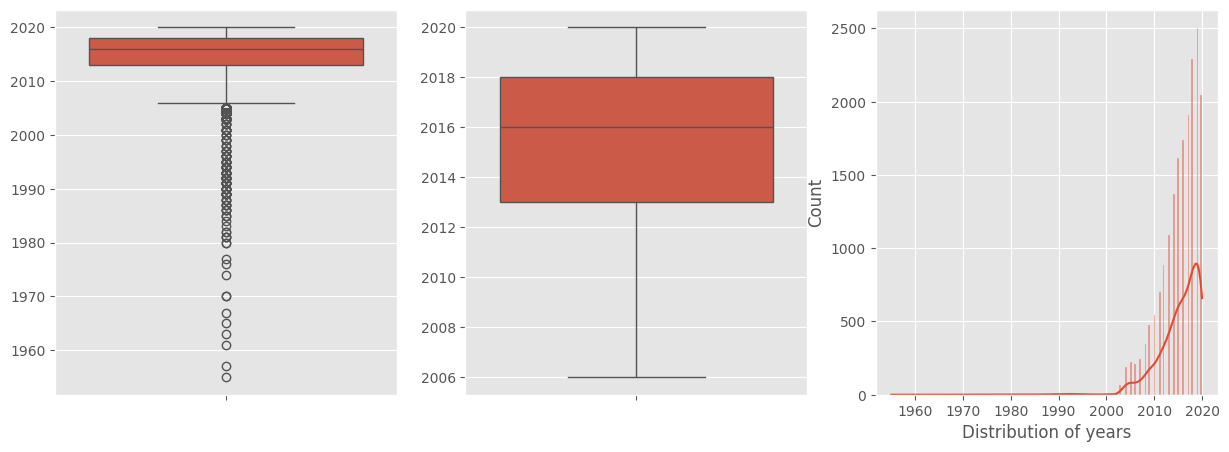

['noone', 'seeming', 'only', 'why', 'moreover', 'off', 'can', 'each', 'almost', 'some']


In [4]:
preprocess.dataCleaning()

### Analysis Base on  `Publish Time` Plots: 

1. The median of `Publish Time` is 2016.

2. The mean of `Publish Time` is 2015.

3. The quartles of box whisker are : `Q1 = 2006, Q2 = 2016, Q3 = 2020`. 

4. The articles that are published before `2006` sounds to be `Outliers `

## Preprocessing Results :


In [5]:
path = "/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/proceed_data/cleaned_dataset.csv"
preprocess = Preprocessing(path)
preprocess.descriptor()


 Basic information from dataset:
----------------------------------------------------------------------------------------------------
 First 5 rows dataset
   Unnamed: 0                                              title  \
0           2  incub period epidemiolog characterist novel co...   
1           3  characterist public health respons coronaviru ...   
2           5   updat estim risk transmiss novel coronaviru ncov   
3           6  real time forecast ncov epidem china februari ...   
4           8  covid outbreak diamond princess cruis ship est...   

                                            abstract  publish_time language  
0  geograph spread novel coronaviru covid infect ...           NaN       en  
1  decemb case unidentifi pneumonia histori expos...           NaN       en  
2  basic reproduct number infecti agent averag nu...           NaN       en  
3  initi cluster sever pneumonia case trigger nco...           NaN       en  
4  cruis ship carri larg number peopl confin 